<a href="https://colab.research.google.com/github/felixJPK/deepfake-vs-real-faces-detection-vit-updated-/blob/main/deepfake_vs_real_faces_detection_vit_(updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries, load and transform data

In [ ]:
# Install necessary Python packages using pip

# Use the 'pip' command to install packages
# The '-q' flag stands for 'quiet,' which means it will suppress most output, making the installation process less verbose
# We're installing the following packages:
# - 'evaluate': This package is likely used for evaluation purposes, but the specific functionality is not clear from this line alone
# - 'transformers': This package is commonly used for natural language processing tasks, such as working with pre-trained language models like BERT or GPT
# - 'datasets': This package provides easy access to various datasets commonly used in machine learning and natural language processing tasks
# - 'mlflow': MLflow is an open-source platform for managing the end-to-end machine learning lifecycle, including tracking experiments, packaging code into reproducible runs, and sharing and deploying models

# Note: Before running this code, make sure you have Python and pip installed on your system.
# Also, ensure you have an internet connection since pip will download and install these packages from PyPI (Python Package Index).
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [ ]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [ ]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinpetersen","key":"388c4fd8735f5f0227c9b0b41fe70276"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:27<00:00, 86.9MB/s]
100% 1.68G/1.68G [00:27<00:00, 66.3MB/s]


In [ ]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [ ]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted((Path('Dataset/').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

190335 190335
(190335, 2)


In [ ]:
df.head()

,image,label
0,Dataset/Test/Fake/fake_0.jpg,Fake
1,Dataset/Test/Fake/fake_1.jpg,Fake
2,Dataset/Test/Fake/fake_10.jpg,Fake
3,Dataset/Test/Fake/fake_100.jpg,Fake
4,Dataset/Test/Fake/fake_1000.jpg,Fake


In [ ]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [ ]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(190402, 2)


In [ ]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

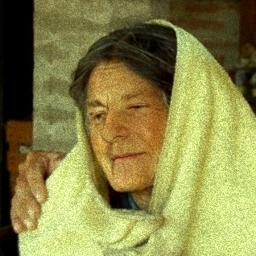

In [ ]:
# Display the first image in the dataset
dataset[0]["image"]

In [ ]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [ ]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['Real', 'Fake'] # list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [ ]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

In [ ]:
# Define the pre-trained ViT model string
model_str = "google/vit-base-patch16-224-in21k" #

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [ ]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [ ]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [ ]:
from transformers import AutoModelForImageClassification, pipeline, Trainer, TrainerCallback, TrainingArguments
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import itertools
import evaluate

In [ ]:
# Mount Google Drive to access/save files
drive.mount('/content/drive')

# Define the base path for your project in Google Drive
base_path = "/content/drive/My Drive/deepfake_vs_real_image_detection"

# Ensure the base directory exists
os.makedirs(base_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Check for existing checkpoints
checkpoint_folders = [
    f for f in os.listdir(base_path)
    if f.startswith("epoch_") or f.startswith("checkpoint-")
]

if checkpoint_folders:
    # Sort folders to get the latest checkpoint
    latest_checkpoint = sorted(
        checkpoint_folders,
        key=lambda x: float(x.split("_")[1]) if x.startswith("epoch_") else int(x.split("-")[1])
    )[-1]
    checkpoint_path = os.path.join(base_path, latest_checkpoint)
    print(f"Resuming training from the latest checkpoint: {checkpoint_path}")
else:
    checkpoint_path = None
    print("No checkpoint found. Training from scratch.")


Resuming training from the latest checkpoint: /content/drive/My Drive/deepfake_vs_real_image_detection/checkpoint-17855


In [ ]:
# Load a pretrained ViT model for image classification
model_str = "google/vit-base-patch16-224-in21k"  # Update with your specific model checkpoint if different
labels_list = ["real", "fake"]
id2label = {i: label for i, label in enumerate(labels_list)}
label2id = {label: i for i, label in enumerate(labels_list)}

In [ ]:
# Create a model instance with the correct output labels
if checkpoint_path:
    # Load from checkpoint
    model = AutoModelForImageClassification.from_pretrained(checkpoint_path)
else:
    # Initialize a new model
    model = AutoModelForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
    model.config.id2label = id2label
    model.config.label2id = label2id

# Display the number of trainable parameters
print(f"Trainable Parameters: {model.num_parameters(only_trainable=True) / 1e6:.2f}M")

Trainable Parameters: 85.80M


In [ ]:
# Load the accuracy metric for evaluation
accuracy = evaluate.load("accuracy")

# Define a function to compute metrics
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {"accuracy": acc_score}

In [ ]:
# Define training arguments
num_train_epochs = 5
args = TrainingArguments(
    output_dir=base_path,  # Save model checkpoints here
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=2,  # Keep only the last 2 checkpoints
    report_to="none"
)

In [ ]:
# Custom callback to save checkpoints in a structured folder
class SaveCheckpointCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Define folder for specific epoch range
        epoch_folder = f"epoch_{state.epoch - 1}_to_{state.epoch}"
        checkpoint_path = os.path.join(args.output_dir, epoch_folder)
        os.makedirs(checkpoint_path, exist_ok=True)

        # Save the model to this folder
        kwargs["model"].save_pretrained(checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

In [ ]:
# Freeze all encoder parameters and unfreeze specific layers
for param in model.vit.encoder.parameters():
    param.requires_grad = False

for name, param in model.vit.encoder.named_parameters():
    if "layer.10" in name or "layer.11" in name:
        param.requires_grad = True

# Verify trainable layers
for name, param in model.named_parameters():
    print(f"{name}: {'Frozen' if not param.requires_grad else 'Trainable'}")

vit.embeddings.cls_token: Trainable
vit.embeddings.position_embeddings: Trainable
vit.embeddings.patch_embeddings.projection.weight: Trainable
vit.embeddings.patch_embeddings.projection.bias: Trainable
vit.encoder.layer.0.attention.attention.query.weight: Frozen
vit.encoder.layer.0.attention.attention.query.bias: Frozen
vit.encoder.layer.0.attention.attention.key.weight: Frozen
vit.encoder.layer.0.attention.attention.key.bias: Frozen
vit.encoder.layer.0.attention.attention.value.weight: Frozen
vit.encoder.layer.0.attention.attention.value.bias: Frozen
vit.encoder.layer.0.attention.output.dense.weight: Frozen
vit.encoder.layer.0.attention.output.dense.bias: Frozen
vit.encoder.layer.0.intermediate.dense.weight: Frozen
vit.encoder.layer.0.intermediate.dense.bias: Frozen
vit.encoder.layer.0.output.dense.weight: Frozen
vit.encoder.layer.0.output.dense.bias: Frozen
vit.encoder.layer.0.layernorm_before.weight: Frozen
vit.encoder.layer.0.layernorm_before.bias: Frozen
vit.encoder.layer.0.layern

In [ ]:
# Create Trainer instance
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
# Add the custom checkpoint callback
trainer.add_callback(SaveCheckpointCallback)

In [ ]:
# Train the model (resume from checkpoint if available)
trainer.train(resume_from_checkpoint=checkpoint_path)

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=17855, training_loss=0.0, metrics={'train_runtime': 0.6627, 'train_samples_per_second': 861924.937, 'train_steps_per_second': 26942.463, 'total_flos': 4.426381192780302e+19, 'train_loss': 0.0, 'epoch': 5.0})

In [ ]:
# Evaluate the model
evaluation_results = trainer.evaluate()
print(f"Evaluation Results: {evaluation_results}")

Evaluation Results: {'eval_loss': 0.4930228590965271, 'eval_accuracy': 0.7823295387403002, 'eval_runtime': 954.4693, 'eval_samples_per_second': 79.794, 'eval_steps_per_second': 9.975, 'epoch': 5.0}


In [ ]:
# Make predictions on test data
outputs = trainer.predict(test_data)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

In [ ]:
# Accuracy and F1 score
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")

Accuracy: 0.7867
F1 Score: 0.7852


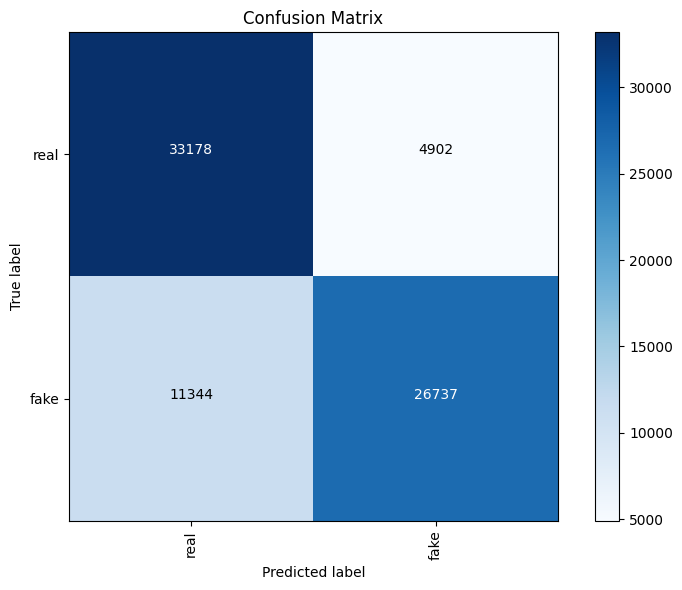


Classification Report:

              precision    recall  f1-score   support

        real     0.7452    0.8713    0.8033     38080
        fake     0.8451    0.7021    0.7670     38081

    accuracy                         0.7867     76161
   macro avg     0.7951    0.7867    0.7852     76161
weighted avg     0.7951    0.7867    0.7852     76161



In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# If the number of labels is small, display a confusion matrix
if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score

probabilities = torch.softmax(torch.tensor(outputs.predictions), dim=1).numpy()

# Iterate over thresholds to find the optimal one
thresholds = np.linspace(0, 1, 101)  # 101 points from 0 to 1
f1_scores = []
optimal_threshold = 0
best_f1 = 0

for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred = (probabilities[:, 1] >= threshold).astype(int)  # Index 1 corresponds to 'Fake'

    # Calculate F1 score for this threshold
    f1 = f1_score(y_true, y_pred, average='macro')
    f1_scores.append(f1)

    # Update optimal threshold if the current F1 score is better
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

# Print the optimal threshold
print(f"Optimal Threshold: {optimal_threshold:.2f} with F1 Score: {best_f1:.4f}")

Optimal Threshold: 0.46 with F1 Score: 0.7916


In [ ]:
# Save the final model and processor
final_model_path = os.path.join(base_path, "final_model")
trainer.save_model(final_model_path)
processor.save_pretrained(final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to /content/drive/My Drive/deepfake_vs_real_image_detection/final_model


# Send model to Huggingface

In [ ]:
!pip install transformers huggingface_hub

In [ ]:
# Import the necessary module to interact with the Hugging Face Hub.
from huggingface_hub import notebook_login

# Perform a login to the Hugging Face Hub.
notebook_login()

In [ ]:
from transformers import AutoModelForImageClassification, ViTImageProcessor
from huggingface_hub import HfApi, Repository

# Load your model and processor
final_model_path = "/content/drive/My Drive/deepfake_vs_real_image_detection/final_model"
model = AutoModelForImageClassification.from_pretrained(final_model_path)
processor = ViTImageProcessor.from_pretrained(final_model_path)

# Push the model and processor to Hugging Face
model.push_to_hub("yithh/ViT-DeepfakeDetection")
processor.push_to_hub("yithh/ViT-DeepfakeDetection")

print("Model and tokenizer uploaded to Hugging Face.")

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Model and tokenizer uploaded to Hugging Face.
